# Running an MSTIS simulation

Now we will use the initial trajectories we obtained from bootstrapping to run an MSTIS simulation. This will show both how objects can be regenerated from storage and how regenerated equivalent objects can be used in place of objects that weren't stored.

Tasks covered in this notebook:
* Loading OPS objects from storage
* Creating initial conditions for a path sampling simulation
* Setting up and running path sampling simulations
* Visualizing trajectories while the path sampling is running

In [1]:
from __future__ import print_function
%matplotlib inline
import openpathsampling as paths
import numpy as np

## Setting up the simulation

### Loading from storage

First we'll reload some of the stuff we stored before. Of course, this starts with opening the file.

In [2]:
old_store = paths.Storage("mstis_bootstrap.nc", mode='r')

A lot of information can be recovered from the old storage, and so we don't have the recreate it. However, we did not save our network, so we'll have to create a new one. Since the network creates the ensembles, that means we will have to translate the trajectories from the old ensembles to new ensembles.

In [3]:
print("PathMovers: "+ str(len(old_store.pathmovers)))
print("Samples: " +  str(len(old_store.samples)))
print("Ensembles: " + str(len(old_store.ensembles)))
print("SampleSets: " + str(len(old_store.samplesets)))
print("Snapshots: " + str(len(old_store.snapshots)))
print("Networks: " + str(len(old_store.networks)))

PathMovers: 0
Samples: 10
Ensembles: 120
SampleSets: 1
Snapshots: 1176
Networks: 0


Loading from storage is very easy. Each store is a list. We take the 0th snapshot as a template (it doesn't actually matter which one) for the next storage we'll create.

In [4]:
template = old_store.snapshots[0]

Named objects can be found in storage by using their name as a dictionary key. This allows us to load our old engine, collective variables, and states.

In [5]:
engine = old_store.engines['toy_engine']

In [6]:
opA = old_store.cvs['opA']
opB = old_store.cvs['opB']
opC = old_store.cvs['opC']

In [7]:
stateA = old_store.volumes['A']
stateB = old_store.volumes['B']
stateC = old_store.volumes['C']

### Creating new interface set, network, and move scheme

In [8]:
# we could also load the interfaces, but it is just as easy:
interfacesA = paths.VolumeInterfaceSet(opA, 0.0,[0.2, 0.3, 0.4])
interfacesB = paths.VolumeInterfaceSet(opB, 0.0,[0.2, 0.3, 0.4])
interfacesC = paths.VolumeInterfaceSet(opC, 0.0,[0.2, 0.3, 0.4])

Once again, we have everything we need to build the MSTIS network. Recall that this will create all the ensembles we need for the simulation. However, even though the ensembles are semantically the same, these are not the same objects. We'll need to deal with that later.

In [9]:
ms_outers = paths.MSOuterTISInterface.from_lambdas(
    {ifaces: 0.5 
     for ifaces in [interfacesA, interfacesB, interfacesC]}
)
mstis = paths.MSTISNetwork(
    [(stateA, interfacesA),
     (stateB, interfacesB),
     (stateC, interfacesC)],
    ms_outers=ms_outers
).named('mstis')

Finally, we'll create the move scheme. For this, we'll use the default TIS move scheme:

In [10]:
scheme = paths.DefaultScheme(mstis, engine=engine).named("scheme")

## Preparing initial conditions

The OPS object called `Sample` is used to associate a trajectory with a replica ID and an ensemble. The trajectory needs to be associated with an ensemble so we know how to get correct statistics from the many ensembles that we might be sampling simultaneously. The trajectory needs to be associated with a replica ID so that replica exchange approaches can be analyzed.

Because we've created a new network (and therefore new ensembles), we need to associate the previous trajectories with the new ensembles. The main tool to map trajectories to ensembles is the `initial_conditions_from_trajectories` method of a move scheme.

In [11]:
# load the sampleset we have saved before; there is only one in the file
old_sampleset = old_store.samplesets[0]
from_old_sset = scheme.initial_conditions_from_trajectories(old_sampleset)

Missing ensembles:
*  [Out A minus]
*  [Out B minus]
*  [Out C minus]
No extra ensembles.


We are missing trajectories that satisfy the minus ensembles. In real simulations, you usually will have run trajectories in each state (you'll use those to create state/interface definitions). You can (and should) feed those trajectories to the `initial_conditions_from_trajectories`, instead of the complicated code below. That function is smart enough to select a section of the trajectory that satisfies the minus ensemble.

However, in this case, we'll need to run dynamics to create such a trajectory. And because this notebook is also used in our tests, the code is a little more complicated to prevent test failures in unusual circumstances (like having a spontaneous transition in the innermost ensemble).

In [12]:
# CODE IN THIS CELL IS NEEDED FOR TEST SUITE, NOT NORMAL USE

def shoot_until_A_to_A(initial_ensemble, desired_ensemble, sample, engine):
    # we only shoot forward because we know the final frame is the problem
    mover = paths.ForwardShootMover(ensemble=initial_ensemble,
                                    selector=paths.UniformSelector(),
                                    engine=engine)
    while not desired_ensemble(sample):
        change = mover.move_core([sample])
        if desired_ensemble(change.trials[0]):
            sample = change.trials[0]
    
    return sample
    
minus_samples = []
for minus_ensemble in mstis.special_ensembles['minus']:
    # tis_ensemble allows A->B; desired_ensemble only allows A->A 
    initial_state = minus_ensemble.state_vol
    tis_ensemble = mstis.from_state[initial_state].ensembles[0]
    desired_ensemble = paths.TISEnsemble(initial_state, initial_state,
                                         tis_ensemble.interface)
    initial_sample = from_old_sset[tis_ensemble]
    # ensure we're A->A, not A->B
    sample_A_to_A = shoot_until_A_to_A(tis_ensemble, desired_ensemble,
                                       initial_sample, engine)

    # with an A->A segment, just use this to extend into the minus ensemble
    sample = minus_ensemble.extend_sample_from_trajectories(
        sample_A_to_A,
        engine=engine,
        replica=-len(minus_samples) - 1
    )
    minus_samples.append(sample)

Now that we have the necessary trajectories, we create a new sample set using `initial_conditions_from_trajectories`. By adding the `sample_set` keyword, we retain any assignments that existing in the given sample set.

Note that `initial_conditions_from_trajectories` is very flexible about its input. It allow you to provide a sample set, a list of samples, a list of trajectories, or a single trajectory. Above we used a sample set; here we'll use a list of samples.

In [13]:
init_conds = scheme.initial_conditions_from_trajectories(
    minus_samples,
    sample_set=from_old_sset
)

No missing ensembles.
No extra ensembles.


Now we have a sample set with a trajectory for all the ensembles required to start the simulation. We can (and should) double-check that everything is okay with a few simple checks:

In [14]:
# verify that every trajectory satisfies its ensemble
init_conds.sanity_check()

In [15]:
# verify that this initial conditions are valid for this move scheme
scheme.assert_initial_conditions(init_conds)

## Equilibration

In molecular dynamics, you need to equilibrate if you don't start with an equilibrated snapshot (e.g., if you start with you system at an energy minimum, your should equilibrate before you start taking statistics). Similarly, if you start with a set of paths which are far from the path ensemble equilibrium, you need to equilibrate. This could either be because your trajectories are not from the real dynamics (generated with metadynamics, high temperature, etc.) or because your trajectories are not representative of the path ensemble (e.g., if you put transition trajectories into all interfaces).

As with MD, running equilibration can be the same process as running the total simulation. However, in path sampling, it doesn't have to be exactly the same: we can equilibrate without replica exchange moves or path reversal moves, for example. See the appendix at the end of this notebook for an example of that.

For a real simulation, we would probably want to store the equilibration phase. Here, we don't bother to save it, so we use `storage=None`.

In [16]:
equilibration = paths.PathSampling(
    storage=None,
    sample_set=init_conds,
    move_scheme=scheme
)

When using one-way shooting, as we are, part of the trajectory is reused after each shooting move. Therefore, an absolute minimum requirement for equilibration is that all frames from each initial trajectory have been replaced by other frames. We refer to such trajectories as "decorrelated," and OPS has a convenience for running a move scheme until all trajectories are decorrelated.

For a real simulation, it would be much better to equilibrate beyond the point where all paths are decorrelated.

In [17]:
#! skip
# don't run this during testing
equilibration.run_until_decorrelated()

Step 750: All trajectories decorrelated!


In [18]:
# get the final sample set; normally we'd save to a file and reload
equilibrated = equilibration.sample_set

## Production

Now we run the full calculation. Up to here, we haven't been storing any of our results. This time, we'll create a storage file, and we'll save a template snapshot. Then we'll create a new `PathSampling` simulation object. Note that we're using the same move scheme here as we did in the equilibration stage.

In [19]:
# logging creates ops_output.log file with details of what is going on 
#import logging.config
#logging.config.fileConfig("../resources/logging.conf", 
#                          disable_existing_loggers=False)

In [20]:
storage = paths.Storage("mstis.nc", "w")

In [21]:
storage.save(template)

(store.snapshots[BaseSnapshot] : 2 object(s),
 2,
 45194949964858475055439011596080367049)

In [22]:
mstis_calc = paths.PathSampling(
    storage=storage,
    sample_set=equilibrated,
    move_scheme=scheme
)
mstis_calc.save_frequency = 50

The next block sets up a live visualization. This is optional, and only recommended if you're using OPS interactively (which would only be for very small systems). Some of the same tools can be used to play back the behavior after the fact if you want to see the behavior for more complicated systems. You can create a background (here we use the PES contours), and the visualization will plot the trajectories.

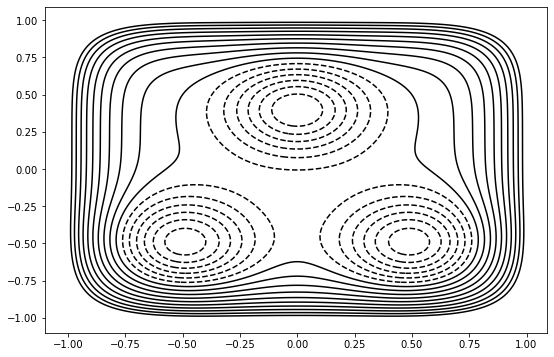

In [23]:
#! skip
# skip this during testing, but leave it for demo purposes
# we use the %run magic because this isn't in a package
%run ../resources/toy_plot_helpers.py
xval = paths.FunctionCV("xval", lambda snap : snap.xyz[0][0])
yval = paths.FunctionCV("yval", lambda snap : snap.xyz[0][1])
mstis_calc.live_visualizer = paths.StepVisualizer2D(mstis, xval, yval,
                                                    [-1.0, 1.0], [-1.0, 1.0])
background = ToyPlot()
background.contour_range = np.arange(-1.5, 1.0, 0.1)
background.add_pes(engine.pes)
mstis_calc.live_visualizer.background = background.plot()
# increase update frequency to speed things up, but it isn't as pretty
mstis_calc.status_update_frequency = 1

Now everything is ready: let's run the simulation! We'll start by running it for 100 MC steps.

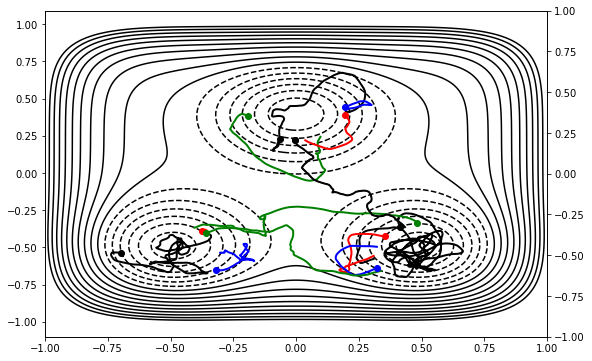

DONE! Completed 100 Monte Carlo cycles.


In [24]:
mstis_calc.run(100)

In RETIS, there are several different move types (shooting, replica exchange, etc.), and each move type can have a different probability of being selected. Moreover, different move types may have different numbers of specific moves (ensembles affected) within them.

This means that if you wanted to run enough steps that, on average, each shooting mover ran 1000 times, you would need to figure out how many trials (of any type) that corresponds to. OPS has tools to make that easy. First, we select a mover (we'll take the first shooting mover as a representative of all shooting movers), and then we use `scheme.n_steps_for_trial` to get the expected number of steps to get that many trials of that mover. Of course, this is only a expected value; the exact number of trials in the simulation will vary.

In [25]:
representative_mover = scheme.movers['shooting'][0]
n_steps = int(scheme.n_steps_for_trials(representative_mover, 1000))
print(n_steps)

20100


Finally, let's run for a lot longer to get enough statistics. Note that this time, we'll run the simulation using `run_until`, which picks up from where we left off, and finishes when a total of `n_steps` trials have been performed.

In [26]:
#! skip
# don't run all those steps in testing!
mstis_calc.live_visualizer = None   # turn off the live visualization
mstis_calc.run_until(n_steps)

Working on Monte Carlo cycle number 20100
Running for 1 hour 39 minutes 22 seconds -  0.30 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 20100 Monte Carlo cycles.


In [27]:
storage.close()

## Appendix: Alternate equilibration scheme

The equilibration above uses the same move scheme as the simulation. As remarked, this is not required: you can equilibrate using a different move scheme that samples the same ensembles. For example, the minus move is run much less frequently in the default TIS scheme, which means that it is a long time before the minus ensemble decorrelates. Additionally, moves like path reversal and replica exchange don't do anything to help the initial decorrelation.

Here's an example of how to create a custom move scheme that uses a shooting move for all ensembles. Note that we don't usually use a shooting move on the minus ensemble (the minus move does the dynamics), but nonetheless, shooting is possible.

In [28]:
from openpathsampling import strategies

We want to create a move scheme that consists of a shooting mover for each ensemble that is used in the move scheme called `scheme`, which we created above. The easiest way to get that is the scheme's `find_used_ensembles` method. However, we could get equivalent information from the network object `mstis`, by looking at its `sampling_ensembles` (normal TIS), `ms_outers` (multiple state outer), and `minus_ensembles`.

In [29]:
all_ensembles = scheme.find_used_ensembles()

In [30]:
shooting_strat = strategies.OneWayShootingStrategy(
    selector=paths.UniformSelector(),
    ensembles=all_ensembles,
    engine=engine
)

# all custom strategies need a global-level "OrganizeBy" strategy
# this is the standard one to use
global_strat = strategies.OrganizeByMoveGroupStrategy()

In [31]:
equil_scheme = paths.MoveScheme(mstis)
equil_scheme.append([shooting_strat, global_strat])

In [32]:
custom_equil = paths.PathSampling(
    storage=None,
    move_scheme=equil_scheme,
    sample_set=init_conds
)

In [33]:
#! skip
custom_equil.run_until_decorrelated()

Step 254: All trajectories decorrelated!
